In [1]:
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from IPython.display import HTML
from matplotlib import animation
from matplotlib.patches import Polygon
import cv2

# Let's first define hyperparameters. In our case, we set the image height H and width H to 128 pixels.
H, W = 128, 128

In [2]:
###########################
##### Helper Function #####
###########################
def get_cube(center=(0, 0, 2), rotation_angles=[0., 0., 0.], with_normals=False, scale=1.):
    ''' Returns an array containing the faces of a cube.

    Args:
    center (tuple): center of the cube
    rotation_angles (tuple): Euler angles describing the rotation of the cube
    with_normals (bool): whether to return the normal vectors of the faces
    scale (float): scale of cube

    '''
    # A cube consists of 6 faces and 8 corners:
    #   +----+
    #  /    /|
    # +----+ |
    # |    | +
    # |    |/
    # +----+
    # Let's first consider the unit cube. The corners are:
    corners = np.array([(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)])
    # Let's now center the cube at (0, 0, 0)
    corners = corners - np.array([0.5, 0.5, 0.5], dtype=np.float32).reshape(1, 3)
    # Let's scale the cube#按比例缩放
    corners = corners * scale
    # And we rotate the cube wrt. the input rotation angles#给定的欧拉角生成旋转矩阵
    rot_mat = R.from_euler('xyz', rotation_angles, degrees=True).as_matrix()
    corners = np.matmul(corners, rot_mat.T)#矩阵点积乘
    # Finally, we shift the cube according to the input center tuple
    corners = corners + np.array(center, dtype=np.float32).reshape(1, 3)

    # The 6 faces of the cube are then given as:
    faces = np.array([
    # all faces containing (0, 0, 0)
    [corners[0], corners[1], corners[3], corners[2]],
    [corners[0], corners[1], corners[5], corners[4]],
    [corners[0], corners[2], corners[6], corners[4]],
    # all faces containing (1, 1, 1)
    [corners[-1], corners[-2], corners[-4], corners[-3]],
    [corners[-1], corners[-2], corners[-6], corners[-5]],
    [corners[-1], corners[-3], corners[-7], corners[-5]],
    ])

    if with_normals:
        normals = np.array([(-1, 0, 0), (0, -1, 0), (0, 0, -1), (1, 0, 0), (0, 1, 0), (0, 0, 1)])
        normals = np.matmul(normals, rot_mat
                            .T)
        return faces, normals
    else:
        return faces

In [3]:
###########################
#### Exercise Function ####
###########################
def get_camera_intrinsics(fx=70, fy=70, cx=W/2., cy=H/2.):
    ''' Returns the camera intrinsics matrix.

    Hint: The array should be of size 3x3 and of dtype float32 (see the assertion below)

    Args:
    fx (float): focal length in x-direction f_x
    fy (float): focal length in y-direction f_y
    cx (float): x component of the principal point
    cy (float): y compontent of th principal point
    '''
    K = np.array([
                [fx, 0, cx],
                [0, fy, cy],
                [0, 0,  1],
    ], dtype=np.float32)

    assert(K.shape == (3, 3) and K.dtype == np.float32)
    return K

In [4]:
def get_perspective_projection(x_c, K):
    ''' Projects the 3D point x_c to screen space and returns the 2D pixel coordinates.
    
    Args:
        x_c (array): 3D point in camera space
        K (array): camera intrinsics matrix (3x3)
    '''
    assert(x_c.shape == (3,) and K.shape == (3, 3))
    
    # 1.) Project points3D to camera space
    xc_projected = np.matmul(K, x_c)
    
    # 2.) uv is now a three-dimensional inhomogenous vector. To obtain the final pixel coordinates
    # you need to calculate the augmented vector and then return extract the first two coordinates
    # and return them.
    x_s = xc_projected[:2] / xc_projected[-1]
    assert(x_s.shape == (2,))
    return x_s

In [5]:
###########################
##### Helper Function #####
###########################
def project_cube(cube, K):
    ''' Projects the cube.
    
    Args:
        cube (array): cube
        K (array): camera intrinsics matrix
    '''
    s = cube.shape
    assert(s[-1] == 3)
    cube = cube.reshape(-1, 3)
    projected_cube = np.stack([get_perspective_projection(p, K) for p in cube])
    projected_cube = projected_cube.reshape(*s[:-1], 2)#重塑
    return projected_cube

In [6]:
###########################
##### Helper Function #####
###########################
def plot_projected_cube(projected_cube, figsize=(5, 5), figtitle=None, colors=None, face_mask=None):
    ''' Plots the projected cube.

    Args:
    projected_cube (array): projected cube (size 6x4x2)
    figsize (tuple): size of the figure
    colors (list): list of colors for polygons. If None, 'blue' is used for all faces
    face_mask (array): mask for individual faces of the cube. If None, all faces are drawn.
    '''
    assert(projected_cube.shape == (6, 4, 2))
    fig, ax = plt.subplots(figsize=figsize)
    if figtitle is not None:
        fig.suptitle(figtitle)
    if colors is None:
        colors = ['C0' for i in range(len(projected_cube))]
    if face_mask is None:
        face_mask = [True for i in range(len(projected_cube))]
    ax.set_xlim(0, W), ax.set_ylim(0, H)
    ax.set_xlabel('Width'), ax.set_ylabel("Height")
    for (cube_face, c, mask) in zip(projected_cube, colors, face_mask):
        if mask:
            ax.add_patch(Polygon(cube_face, color=c))
    plt.show()

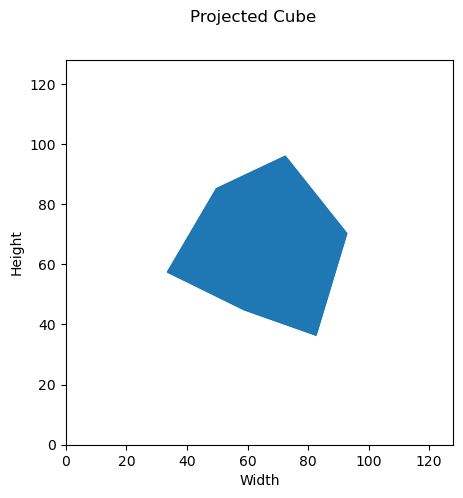

In [7]:
K = get_camera_intrinsics()
cube = get_cube(rotation_angles=[30, 50, 0])
projected_cube = project_cube(cube, K)
plot_projected_cube(projected_cube, figtitle='Projected Cube')

In [8]:
###########################
#### Exercise Function ####
###########################
def get_face_color(normal, point_light_direction=(0, 0, 1)):
    ''' Returns the face color for input normal.
    
    Args:
        normal (array): 3D normal vector
        point_light_direction (tuple): 3D point light direction vector
    '''
    assert(normal.shape == (3,))
    point_light_direction = np.array(point_light_direction, dtype=np.float32)
    light_intensity = np.sum(normal * (-point_light_direction))
    color_intensity = 0.1 + (light_intensity * 0.5 + 0.5) * 0.8
    color = np.stack([color_intensity for i in range(3)])
    return color

In [9]:
###########################
##### Helper Function #####
###########################
def get_face_colors(normals, light_direction=(0, 0, 1)):
    ''' Returns the face colors for given normals and viewing direction.

    Args:
    normals (array): face normals (last dimension is 3)
    light_direction (tuple): light direction vector
    '''
    colors = np.stack([get_face_color(normal, light_direction) for normal in normals])
    return colors

In [10]:
###########################
##### Helper Function #####
###########################
def get_face_mask(cube, normals, camera_location=(0, 0, 0)):
    ''' Returns a mask for each face of the cube whether it is visible when projected.
    
    Args:
    cube (array): cube faces
    normals (array): face normals (last dimension is 3)
    camera_location (tuple): viewing camera location vector
    '''
    assert(cube.shape == (6, 4, 3) and normals.shape[-1] == 3)
    camera_location = np.array(camera_location).reshape(1, 3) 

    face_center = np.mean(cube, axis=1)
    viewing_direction = camera_location - face_center
    dot_product = np.sum(normals * viewing_direction, axis=-1)
    mask = dot_product > 0.0
    return mask

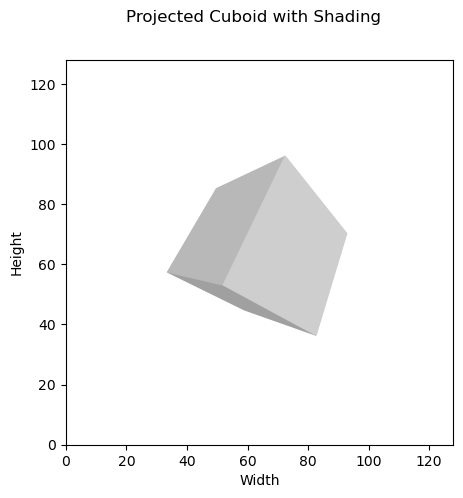

In [11]:
cube, normals = get_cube(rotation_angles=[30, 50, 0], with_normals=True)
colors = get_face_colors(normals)
mask = get_face_mask(cube, normals)
projected_cube = project_cube(cube, get_camera_intrinsics())
plot_projected_cube(projected_cube, figtitle="Projected Cuboid with Shading", colors=colors, face_mask=mask)

In [12]:
###########################
##### Helper Function #####
###########################
def get_animation(K_list, cube_list, figsize=(5, 5), title=None):
    ''' Create a matplotlib animation for the list of camera matrices and cubes with face normals.

    Args:
    K_list (list): list of camera matrices
    cube_list (list): list of cubes
    figsize (tuple): matplotlib figsize
    title (str): if not None, the title of the figure
    '''
    assert(len(K_list) == len(cube_list))

    # split cube_list into cubes and normals
    cubes = [i[0] for i in cube_list]
    normals = [i[1] for i in cube_list]

    # get face colors and masks
    colors = [get_face_colors(normals_i) for normals_i in normals]
    masks = [get_face_mask(cube_i, normals_i) for (cube_i, normals_i) in zip(cubes, normals)]

    # get projected cubes
    projected_cubes = [project_cube(cube, Ki) for (cube, Ki) in zip(cubes, K_list)]

    # initialize plot
    uv = projected_cubes[0]
    patches = [Polygon(uv_i, closed=True, color='white') for uv_i in uv]

    # Define animation function
    def animate(n):
        ''' Animation function for matplotlib visualizations.
        '''
        uv = projected_cubes[n]
        color = colors[n]
        mask = masks[n]
        for patch, uv_i, color_i, mask_i in zip(patches, uv, color, mask):
            if mask_i:
                patch.set_xy(uv_i)
                patch.set_color(color_i)
            else:
                uv_i[:] = -80
                patch.set_color(color_i)
                patch.set_xy(uv_i)
        return patches

    fig, ax = plt.subplots(figsize=figsize)
    if title is not None:
        fig.suptitle(title)
    plt.close()
    ax.set_xlim(0, W)
    ax.set_ylim(0, H)
    for patch in patches:
        ax.add_patch(patch)
    anim = animation.FuncAnimation(fig, animate, frames=len(K_list), interval=100, blit=True)
    return anim

In [13]:
K_list = [get_camera_intrinsics() for i in range(30)]
cube_list = [get_cube(rotation_angles=[0, angle, 0], with_normals=True) for angle in np.linspace(0, 360, 30)]
anim = get_animation(K_list, cube_list, title="Rotation of Cube")
HTML(anim.to_html5_video())

In [14]:
K_list = [get_camera_intrinsics(fx=f) for f in np.linspace(10, 150, 30)]
cube_list = [get_cube(rotation_angles=(0, 30, 50), with_normals=True) for i in range(30)]
anim = get_animation(K_list, cube_list, title="Change of focal length along the x-axis.")
HTML(anim.to_html5_video())

In [15]:
###########################
#### Exercise Function ####
###########################
K_list = [get_camera_intrinsics(fx=f, fy=f) for f in np.linspace(10, 150, 30)]
cube_list = [get_cube(rotation_angles=(0, 30, 50), with_normals=True) for i in range(30)]
anim = get_animation(K_list, cube_list, title="Change of focal length along both axes.")
HTML(anim.to_html5_video())

In [16]:
###########################
#### Exercise Function ####
###########################
K_list = [get_camera_intrinsics() for i in range(30)]
cube_list = [get_cube(center=(i, 0, 2), rotation_angles=(0, 30, 50), with_normals=True) for i in np.linspace(-2, 2, 30)]
anim = get_animation(K_list, cube_list, title="Change of cube translation along y-axis.")
HTML(anim.to_html5_video())

In [17]:
###########################
#### Exercise Function ####
###########################
K_list = [get_camera_intrinsics(fx=f, fy=f) for f in np.linspace(30, 500, 30)]
cube_list = [get_cube(center=(0, 0, i), rotation_angles=(30, 50, 0), with_normals=True) for i in np.linspace(1., 10, 30)]
anim = get_animation(K_list, cube_list, title="Dolly Zoom Effect.")
HTML(anim.to_html5_video())

In [18]:
###########################
#### Exercise Function ####
###########################
def get_orthographic_projection(x_c):
    ''' Projects the 3D point in camera space x_c to 2D pixel coordinates using an orthographic projection.
    
    Args:
        x_c (array): 3D point in camera space
    '''
    assert(x_c.shape == (3,))

    # 1.) Define 2x3 projection matrix
    K = np.array([
                [1, 0, 0],
                [0, 1, 0],
    ], dtype=np.float32)

    # 1.) Project points3D to camera space
    x_s = np.matmul(K, x_c)
    assert(x_s.shape == (2,))
    return x_s

In [19]:
def project_cube_orthographic(cube):
    ''' Projects the cube using an orthographic projection.
    
    Args:
        cube (array): cube
    '''
    s = cube.shape
    assert(s[-1] == 3)
    cube = cube.reshape(-1, 3)
    projected_cube = np.stack([get_orthographic_projection(p) for p in cube])
    projected_cube = projected_cube.reshape(*s[:-1], 2)
    return projected_cube

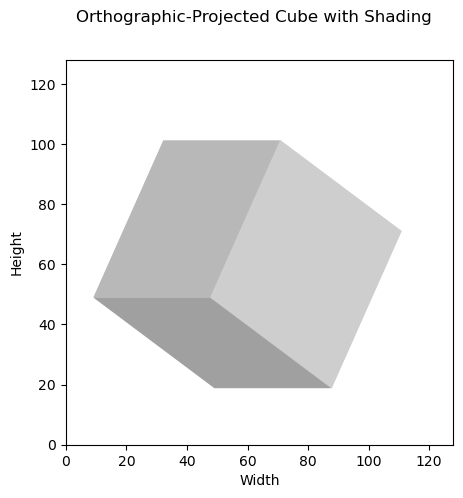

In [20]:
cube, normals = get_cube(center=(60., 60., 100), rotation_angles=[30, 50, 0], scale=60., with_normals=True)
colors = get_face_colors(normals)
mask = get_face_mask(cube, normals)
projected_cube = project_cube_orthographic(cube)
plot_projected_cube(projected_cube, figtitle="Orthographic-Projected Cube with Shading", colors=colors, face_mask=mask)

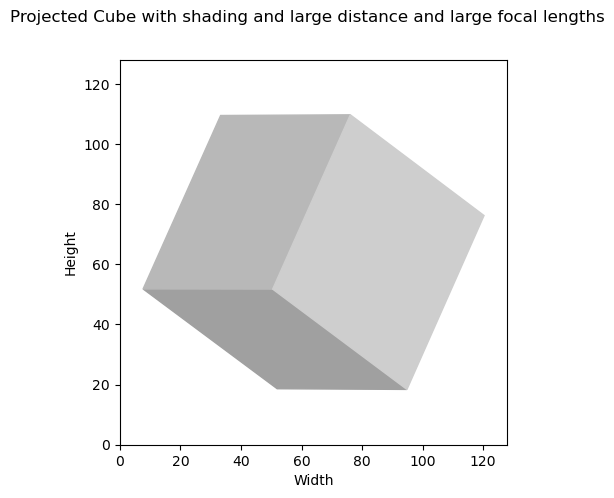

In [21]:
###########################
#### Exercise Function ####
###########################
cube, normals = get_cube(center=(0, 0, 150), rotation_angles=[30, 50, 0], with_normals=True)
K = get_camera_intrinsics(fx=10000, fy=10000)
colors = get_face_colors(normals)
mask = get_face_mask(cube, normals)
projected_cube = project_cube(cube, K)
plot_projected_cube(projected_cube, figtitle="Projected Cube with shading and large distance and large focal lengths", colors=colors, face_mask=mask)

In [25]:
# Load images
img1 = cv2.cvtColor(cv2.imread('image-1.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('image-2.jpg'), cv2.COLOR_BGR2RGB)

# Load matching points
npz_file = np.load('./panorama_points.npz')
points_source = npz_file['points_source']
points_target = npz_file['points_target']

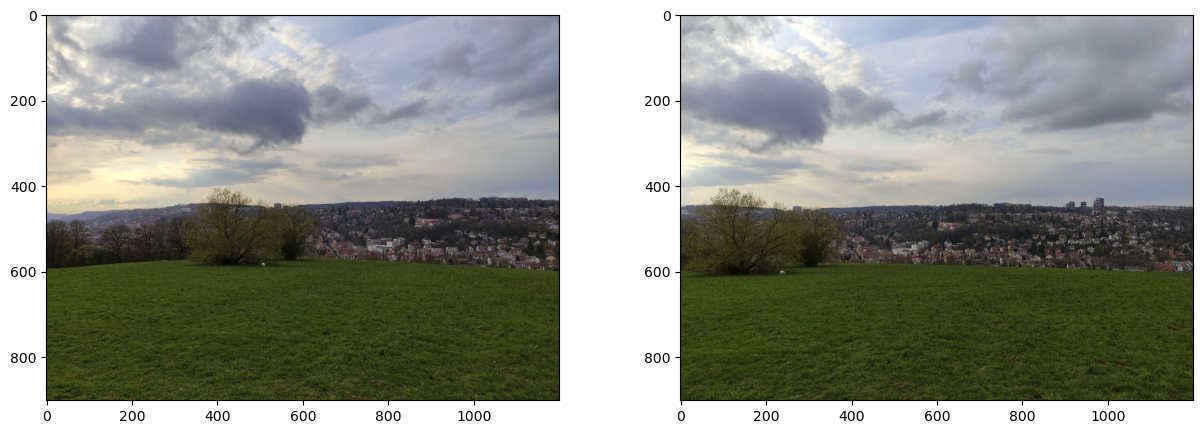

In [26]:
# Let's visualize the images
f = plt.figure(figsize=(15, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.imshow(img1)
ax2.imshow(img2)

In [27]:
###########################
##### Helper Function #####
###########################
def draw_matches(img1, points_source, img2, points_target):
    ''' Returns an image with matches drawn onto the images.
    '''
    r, c = img1.shape[:2]
    r1, c1 = img2.shape[:2]

    output_img = np.zeros((max([r, r1]), c + c1, 3), dtype='uint8')
    output_img[:r, :c, :] = np.dstack([img1])
    output_img[:r1, c:c + c1, :] = np.dstack([img2])

    for p1, p2 in zip(points_source, points_target):
        (x1, y1) = p1[:2]
        (x2, y2) = p2[:2]

        cv2.circle(output_img, (int(x1), int(y1)), 10, (0, 255, 255), 10)
        cv2.circle(output_img, (int(x2) + c, int(y2)), 10, (0, 255, 255), 10)

        cv2.line(output_img, (int(x1), int(y1)), (int(x2) + c, int(y2)), (0, 255, 255), 5)

    return output_img

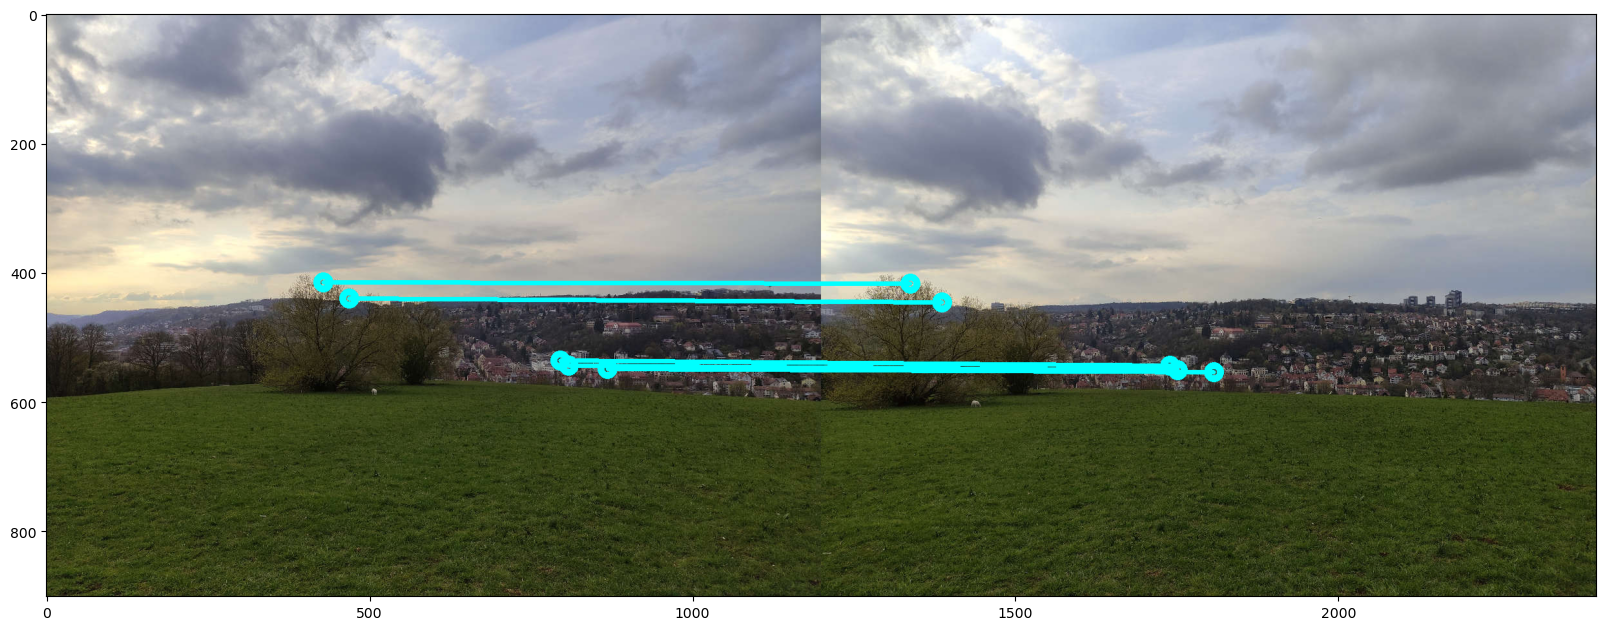

In [28]:
f = plt.figure(figsize=(20, 10))
vis = draw_matches(img1, points_source[:5], img2, points_target[:5])
plt.imshow(vis)

In [29]:
###########################
#### Exercise Function ####
###########################
def get_Ai(xi_vector, xi_prime_vector):
    ''' Returns the A_i matrix discussed in the lecture for input vectors.
    
    Args:
        xi_vector (array): the x_i vector in homogeneous coordinates
        xi_vector_prime (array): the x_i_prime vector in homogeneous coordinates
    '''
    assert(xi_vector.shape == (3,) and xi_prime_vector.shape == (3,))
    zero_vector = np.zeros((3,), dtype=np.float32)
    xi, yi, wi = xi_prime_vector
    
    Ai = np.stack([
        np.concatenate([zero_vector, -wi*xi_vector, yi*xi_vector]),
        np.concatenate([wi*xi_vector, zero_vector, -xi*xi_vector]),
        # np.concatenate([-yi*xi_vector, xi*xi_vector, zero_vector]) this is not needed, so we comment it out
    ])
    assert(Ai.shape == (2, 9))
    return Ai

In [30]:
###########################
#### Exercise Function ####
###########################
def get_A(points_source, points_target):
    ''' Returns the A matrix discussed in the lecture.
    
    Args:
        points_source (array): 3D homogeneous points from source image
        points_target (array): 3D homogeneous points from target image
    '''
    N = points_source.shape[0]
    correspondence_pairs = zip(points_source, points_target)
    
    A = np.concatenate([get_Ai(p1, p2) for (p1, p2) in correspondence_pairs])
    assert(A.shape == (2*N, 9))
    return A